In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

from src.data_generation import generate_weak_features
from src.models import min_norm_solution
from src.metrics import calculate_risks_linf

In [2]:
# Configurações iniciais do teste
n_train = 100
n_test = 1000
delta = 0.05
trials = 20  # Repetições para as barras de erro

# No artigo original, temos m indo de n/10 até n*100
start_power = np.log10(n_train / 10)
end_power = np.log10(n_train * 100)

# Gera 60 pontos distribuídos uniformemente na escala LOG
m_log_dist = np.logspace(start_power, end_power, num=60)

# Converter para inteiros únicos e ordenar
m_list = np.unique(m_log_dist.astype(int))

# Garantir que o ponto crítico m=n esteja na lista para vermos o pico
if n_train not in m_list:
    m_list = np.append(m_list, n_train)
    m_list.sort()

In [3]:
print(f"Simulando para {len(m_list)} valores de m:")
print(f"De {m_list[0]} até {m_list[-1]}")

risks_std_data = []
risks_adv_data = []

# Matrizes para guardar as medianas e erros
raw_data_std = []
raw_data_adv = []

for m in m_list:
    temp_std = []
    temp_adv = []
    
    for _ in range(trials):
        X_train, y_train = generate_weak_features(n_train, m)
        X_test, y_test = generate_weak_features(n_test, m)
        
        beta = min_norm_solution(X_train, y_train)
        
        r_std, r_adv = calculate_risks_linf(X_test, y_test, beta, delta)
        
        temp_std.append(r_std)
        temp_adv.append(r_adv)
        
    raw_data_std.append(temp_std)
    raw_data_adv.append(temp_adv)

Simulando para 61 valores de m:
De 10 até 10000


In [4]:
# Estatísticas de mediana e quartis
def get_stats(raw_data):
    arr = np.array(raw_data)
    med = np.median(arr, axis=1)
    q25 = np.percentile(arr, 25, axis=1)
    q75 = np.percentile(arr, 75, axis=1)
    err_low = med - q25
    err_high = q75 - med
    return med, [err_low, err_high]

med_std, err_std = get_stats(raw_data_std)
med_adv, err_adv = get_stats(raw_data_adv)


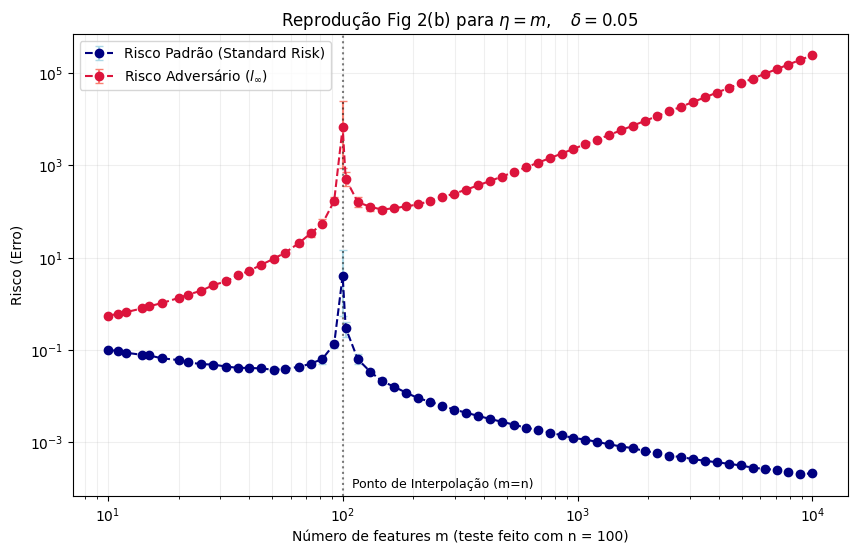

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar Risco Padrão
ax.errorbar(m_list, med_std, yerr=err_std, 
            fmt='--o', color='navy', ecolor='lightblue', 
            capsize=3, elinewidth=1.5, markeredgewidth=1,
            label='Risco Padrão (Standard Risk)')

# Plotar Risco Adversário
ax.errorbar(m_list, med_adv, yerr=err_adv, 
            fmt='--o', color='crimson', ecolor='salmon', 
            capsize=3, elinewidth=1.5, markeredgewidth=1,
            label=r'Risco Adversário ($l_{\infty}$)')

ax.set_xscale('log')
ax.set_yscale('log')

# Linha vertical no pico (m = n)
ax.axvline(x=n_train, color='black', linestyle=':', alpha=0.5)
ax.text(n_train * 1.1, ax.get_ylim()[0]*1.5, 'Ponto de Interpolação (m=n)', fontsize=9)

ax.set_xlabel(f'Número de features m (teste feito com n = 100)')
ax.set_ylabel('Risco (Erro)')
ax.set_title(r'Reprodução Fig 2(b) para $\eta = m, \quad \delta = 0.05$')

ax.legend()
ax.grid(True, which="both", alpha=0.2) # Grid 'both' mostra as linhas do log

plt.show()